# Data Cleaning and Visuallization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from google.colab import drive
import random
from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import GridSearchCV

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_excel('/content/drive/My Drive/COMP_551/A1/data1.xlsx')

In [ ]:
column_headers = ['compactness', 'surface_area', 'wall_area', 'roof_area', 'height', 'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

In [ ]:
df.columns = column_headers

In [ ]:
df.describe()

,compactness,surface_area,wall_area,roof_area,height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   compactness                768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   height                     768 non-null    float64
 5   orientation                768 non-null    int64  
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    int64  
 8   heating_load               768 non-null    float64
 9   cooling_load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [ ]:
df.isna().sum() # No missing values

compactness                  0
surface_area                 0
wall_area                    0
roof_area                    0
height                       0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
cooling_load                 0
dtype: int64

In [ ]:
X=df.iloc[:,:8] # model input
scaler=StandardScaler()
X=scaler.fit_transform(X)

y1=df[['heating_load']].to_numpy().ravel()
y2=df[['cooling_load']].to_numpy().ravel() # ASK: why this not single array?

In [ ]:
y1.shape

(768,)

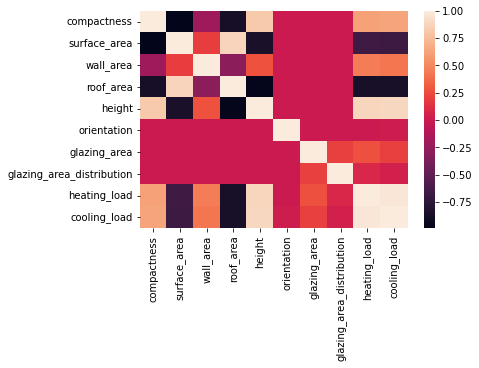

In [ ]:
# correlations of features with themselves and the two targets
cor = df.select_dtypes(include='number').corr()
sns.heatmap(data=cor, cmap='rocket')
plt.show()

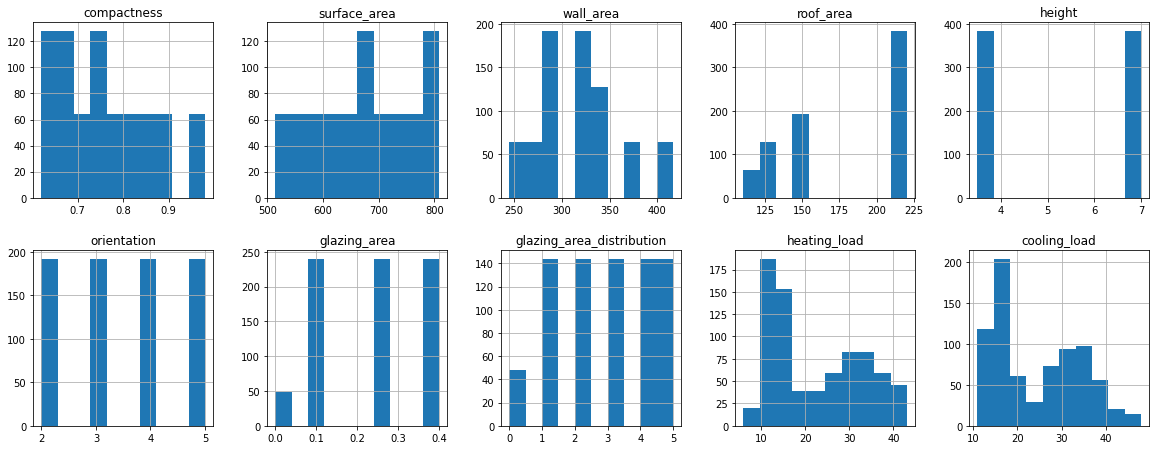

In [ ]:
df.hist(layout=(5,5), figsize=(20,20))
plt.show()

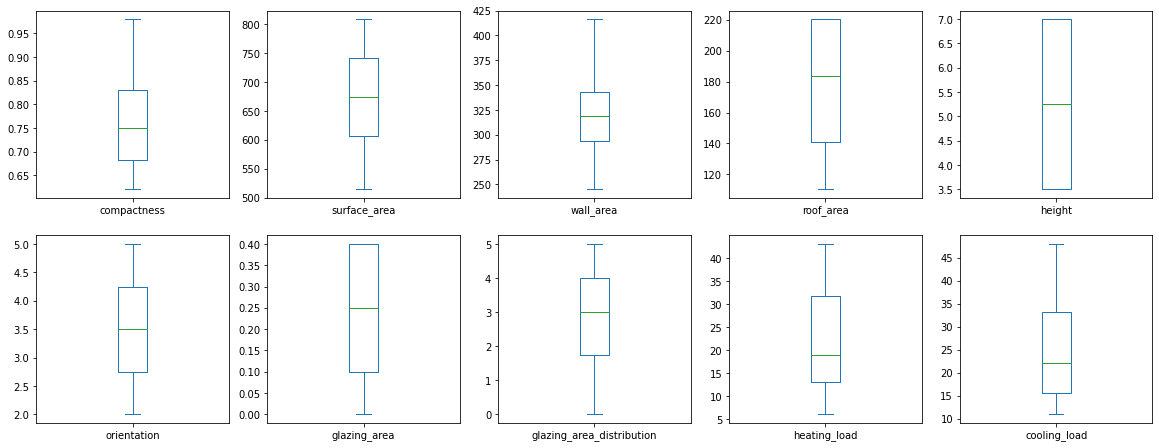

In [ ]:
df.plot(layout=(5,5), figsize=(20,20), subplots=True, kind='box')
plt.show()

# Implementing Linear Regression

## Analytical Linear Regression

In [ ]:
class LinearRegressionAnalytical:
    def __init__(self, add_bias=True):
        self.w=[]
        self.add_bias = add_bias
        pass
    
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        self.w = np.linalg.inv(x.T @ x)@x.T@y
        return self, self.w
    
    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


In [ ]:
# For heating load

X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=0.80, random_state=42)
model=LinearRegressionAnalytical()
weights=model.fit(x=X_train, y=y_train,)
y_predict=model.predict(X_test)
mean_squared_error(y_test, y_predict)

13.483735649433852

In [ ]:
# For cooling load

X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=0.80, random_state=42)
model=LinearRegressionAnalytical()
weights=model.fit(x=X_train, y=y_train,)
y_predict=model.predict(X_test)
mean_squared_error(y_test, y_predict)

13.817774730613202

In [ ]:
feats=['compactness',
 'surface_area',
 'wall_area',
 'roof_area',
 'height',
 'orientation',
 'glazing_area',
 'glazing_area_distribution',
 'bias']
data = {'feature': feats, 'weights': weights[1]}
weights_df=pd.DataFrame.from_dict(data)

## Linear Regression with Gradient Descent

### Model

In [ ]:
# branch for implementing convergence speed visualizer
# GOAL: Return a list of costs at each iteration of gradient descent algorithm

class LinearRegression:
    def __init__(self, add_bias=True): # ASK: where should add_bias stuff go?
        self.w=0
        self.add_bias = add_bias
        self.w_history=[]
        self.indices=[]
        self.l2_reg=0
        self.sum_of_gradient=0
        self.costs=[]
        pass

    def gradient(self, x, y, w): # define the gradient function                      
      yh =  x @ w 
      N, D = x.shape
      x_transpose=np.transpose(x)
      delta_y=yh - y
      grad = 1/N*(x_transpose @ (delta_y))+2*self.l2_reg*self.w # ASK: gradient formula in lecture slides don't seem to have a 0.5. Isn't that only for stochastic?
      return (grad)

    # Ask: this is an okay way to generate the batches, right?
    def batch_generator(self,x, y, size, indices):
      random_list=[]
      if len(indices)<size:
        random_list=indices
      else:
        random_list=random.sample(indices, size)
      indices = [ele for ele in indices if ele not in random_list]
      x_mini=x[random_list]
      
      y_mini=y[random_list]
      return x_mini, y_mini, indices

    def cost(self, w, y, x):
      cost_value=(1/2)*((y-x @ w).T @ (y-x @ w))
      return cost_value

    def fit(self, x, y, learning_rate=0.001, 
            max_iters=1e4, epsilon=1e-8, record_history=False, batch_size=8, l2_reg=0, decay_rate=0): # default values for learning rate and batch size.
        if x.ndim == 1: # ASK: What is this bit of code doing?
            x = x[:, None]
        if self.add_bias: # ASK: We should always add bias, right?
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        self.l2_reg=l2_reg # setting the regularization parameter
        N,D = x.shape # N: number of records D: number of features
        number_of_batches=int(N/batch_size)
        self.w=(np.zeros(D))                                # initialize the weights to 0
        grad=np.inf # ASK: What is the purpose of setting the grad to inf
        t = 1
        temp_all_indices=[x for x in range(N)]
        self.indices = temp_all_indices # setting list of indices
        # cost would have to be appended after each update
        # print(t)
        # print(f"N: {N}")
        # print(f"batch_size: {batch_size}")
        # print(f"Number of batches: {number_of_batches}")
        # print(N//batch_size)
        while np.linalg.norm(grad) > epsilon and t < max_iters:
            # batch_generator function call goes here
            if len(self.indices)==0:
              self.indices=temp_all_indices 
            x_mini, y_mini, new_indices = self.batch_generator(x, y, batch_size, self.indices)
            self.indices=new_indices
            grad = self.gradient(x, y, self.w)             # compute the gradient with present weight
            self.sum_of_gradient=grad+self.sum_of_gradient*decay_rate # update running sum
            self.w = self.w - learning_rate * self.sum_of_gradient         # weight update step

            # cost would have to be appended after each epoch
            if t%(number_of_batches)==0:
              cost_val = np.log(self.cost(w=self.w,y=y_mini,x=x_mini))
              self.costs.append(cost_val)

            if record_history:
                self.w_history.append(self.w)
            t += 1
        return [self.w, list(self.costs)] # weight and costs of the trained models
    
    def predict(self, x):
        N,D = x.shape
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

## Predicting heating load

### Initial Run

In [ ]:
# Test error, and train error
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=0.60, random_state=42)
model=LinearRegression()
weights=(model.fit(x=X_train, y=y_train))[0]
y_predict_test=model.predict(X_test)
test_error=mean_squared_error(y_test, y_predict_test)
y_predict_train=model.predict(X_train)
train_error=mean_squared_error(y_train, y_predict_train)
print(f"The training error is: {train_error}\nThe test error is: {test_error}")

The training error is: 9.432872788976221
The test error is: 10.572956736545297


In [ ]:
feats=['compactness',
 'surface_area',
 'wall_area',
 'roof_area',
 'height',
 'orientation',
 'glazing_area',
 'glazing_area_distribution',
 'bias']
data = {'feature': feats, 'weights': weights}
weights_df=pd.DataFrame.from_dict(data)
weights_df

,feature,weights
0,compactness,-0.637496
1,surface_area,-1.123707
2,wall_area,2.591332
3,roof_area,-2.347274
4,height,5.241643
5,orientation,-0.054931
6,glazing_area,2.743368
7,glazing_area_distribution,0.372052
8,bias,22.176592


### Varying training data size

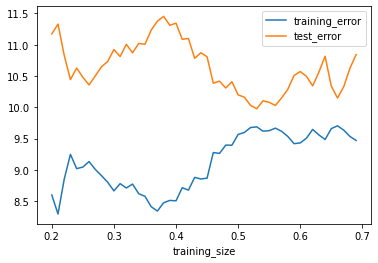

,training_size,training_error,test_error
0,0.20,8.600983,11.174430
1,0.21,8.297443,11.330649
2,0.22,8.853749,10.831793
3,0.23,9.250107,10.444419
4,0.24,9.022323,10.627768
5,0.25,9.047031,10.482378
6,0.26,9.135669,10.359387
7,0.27,9.009897,10.502993
8,0.28,8.909768,10.648313
9,0.29,8.804848,10.733405


In [ ]:
# Test error, and train error with varying training data size

training_size=[x*0.01 for x in range(20,70)]
train_error_list=[]
test_error_list=[]

for x in training_size:
  X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=x, random_state=42)
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train))[0]
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  y_predict_train=model.predict(X_train)
  train_error=mean_squared_error(y_train, y_predict_train)
  train_error_list.append(train_error)
  test_error_list.append(test_error)

data = {'training_size': training_size, 'training_error': train_error_list, 'test_error': test_error_list}
varied_training_size_df=pd.DataFrame.from_dict(data)
varied_training_size_df.plot(x='training_size')
plt.show()
varied_training_size_df

### Mini-batch gradient descent with varying batch size

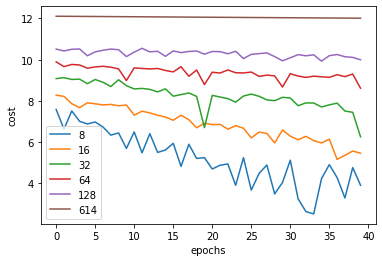

In [ ]:
# varying the batch size
batch_sizes=[8, 16, 32, 64, 128, int(768*0.8)]
error_list=[]
time_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=.80, random_state=42)

# error plots
for size in batch_sizes:
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train,batch_size=size))[0]
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'batch_size': batch_sizes, 'test_error': error_list}
varied_batch_size_df=pd.DataFrame.from_dict(error_data)
varied_batch_size_df.plot(x='batch_size', y='test_error')
plt.show()

# convergence speed plots
all_costs={}
for size in batch_sizes: # change size
  model=LinearRegression()
  fit_return_list=model.fit(x=X_train, y=y_train,batch_size=size) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(size)] = costs

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))
all_costs

for key in all_costs:
  all_costs[key] = all_costs[key][0:60]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

### Varying learning rates

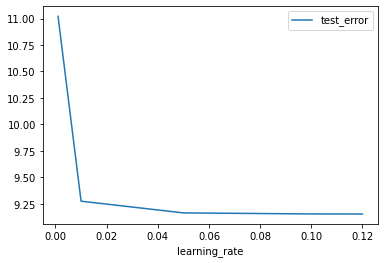

In [ ]:
# varying the learning rates

learning_rates=[0.001, 0.01, 0.05, 0.1, 0.12] # change Maybe get rid of 0.12
error_list=[]
time_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=.80, random_state=42)


# error plots
for lr in learning_rates: # change size and batch names
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train, learning_rate=lr))[0] # change
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'learning_rate': learning_rates, 'test_error': error_list} # change
varied__df=pd.DataFrame.from_dict(error_data)
varied__df.plot(x='learning_rate', y='test_error') # change
plt.show()

### Varying regularization parameter

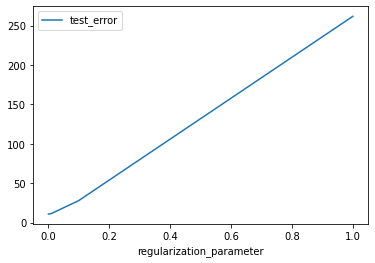

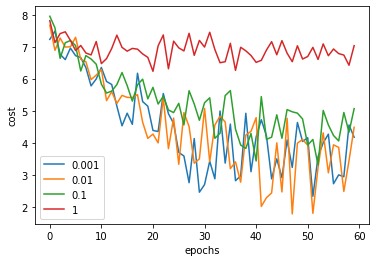

In [ ]:
# varying the regularization parameter
# around 7 changes

regularization_parameters=[0.001, 0.01, 0.1, 1] # change
error_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=.80, random_state=42)

# error plots
for rp in regularization_parameters: # change size and batch names
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train, l2_reg=rp))[0] # change
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'regularization_parameter': regularization_parameters, 'test_error': error_list} # change
varied__df=pd.DataFrame.from_dict(error_data)
varied__df.plot(x='regularization_parameter', y='test_error') # change
plt.show()

# convergence speed plots
all_costs={}
for rp in regularization_parameters: # change 
  model=LinearRegression()
  fit_return_list=model.fit(x=X_train, y=y_train,l2_reg=rp) # change
  costs=fit_return_list[1]
  all_costs[str(rp)] = costs # change

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))

for key in all_costs:
  all_costs[key] = all_costs[key][0:60]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show() # Better legend

### Adding momentum and varying decay rate

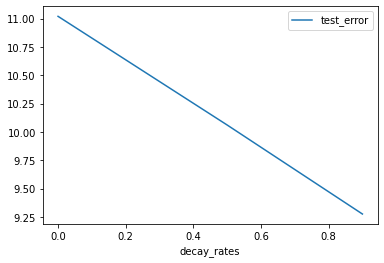

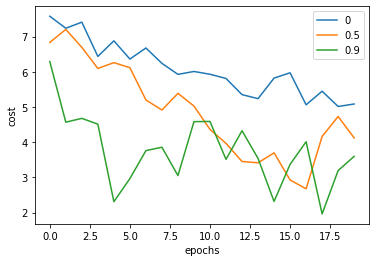

In [ ]:
# varying the regularization parameter
# around 7 changes

decay_rates=[0, 0.5, 0.9] # change
error_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size=.80, random_state=42)

# error plots
for dr in decay_rates: # change size and batch names
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train, decay_rate=dr))[0] # change
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'decay_rates': decay_rates, 'test_error': error_list} # change
varied__df=pd.DataFrame.from_dict(error_data)
varied__df.plot(x='decay_rates', y='test_error') # change
plt.show()

# convergence speed plots
all_costs={}
for dr in decay_rates: # change 
  model=LinearRegression()
  fit_return_list=model.fit(x=X_train, y=y_train, decay_rate=dr) # change
  costs=fit_return_list[1]
  all_costs[str(dr)] = costs # change

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))
all_costs
for key in all_costs:
  all_costs[key] = all_costs[key][0:20]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show() # Better legend

## Predicting cooling load

### Initial Run

In [ ]:
# Test error, and train error
X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=0.80, random_state=42)
model=LinearRegression()
weights=(model.fit(x=X_train, y=y_train))[0]
y_predict_test=model.predict(X_test)
test_error=mean_squared_error(y_test, y_predict_test)
y_predict_train=model.predict(X_train)
train_error=mean_squared_error(y_train, y_predict_train)
print(f"The training error is: {train_error}\nThe test error is: {test_error}")

The training error is: 11.621003085915948
The test error is: 12.304611960505666


In [ ]:
feats=['compactness',
 'surface_area',
 'wall_area',
 'roof_area',
 'height',
 'orientation',
 'glazing_area',
 'glazing_area_distribution',
 'bias']
data = {'feature': feats, 'weights': weights}
weights_df=pd.DataFrame.from_dict(data)
weights_df

,feature,weights
0,compactness,-0.687360
1,surface_area,-1.140824
2,wall_area,2.111192
3,roof_area,-2.132078
4,height,5.241264
5,orientation,0.027651
6,glazing_area,1.997590
7,glazing_area_distribution,0.045435
8,bias,24.518429


### Varying training data size

For training size of 20.0%, the training error is 11.359130313629448 and the test error is 12.525911468772883
For training size of 30.0%, the training error is 11.33545630838487 and the test error is 12.617478585785385
For training size of 40.0%, the training error is 11.056618489074683 and the test error is 12.739610298166694
For training size of 50.0%, the training error is 11.94875336471395 and the test error is 11.686890015324854
For training size of 60.0%, the training error is 12.03420072216778 and the test error is 11.230754469365731
For training size of 70.0%, the training error is 11.552973504269856 and the test error is 12.068967577075366
For training size of 80.0%, the training error is 11.621003085915948 and the test error is 12.304611960505666


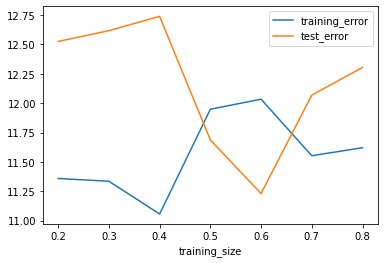

,training_size,training_error,test_error
0,0.2,11.359130,12.525911
1,0.3,11.335456,12.617479
2,0.4,11.056618,12.739610
3,0.5,11.948753,11.686890
4,0.6,12.034201,11.230754
5,0.7,11.552974,12.068968
6,0.8,11.621003,12.304612


In [ ]:
# Test error, and train error with varying training data size

training_size=[0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]
train_error_list=[]
test_error_list=[]

for x in training_size:
  X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=x, random_state=42)
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train))[0]
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  y_predict_train=model.predict(X_train)
  train_error=mean_squared_error(y_train, y_predict_train)
  print(f"For training size of {x*100}%, the training error is {train_error} and the test error is {test_error}")
  train_error_list.append(train_error)
  test_error_list.append(test_error)

data = {'training_size': training_size, 'training_error': train_error_list, 'test_error': test_error_list}
varied_training_size_df=pd.DataFrame.from_dict(data)
varied_training_size_df.plot(x='training_size')
plt.show()
varied_training_size_df

### Mini-batch gradient descent with varying batch size

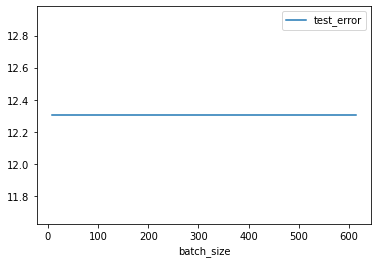

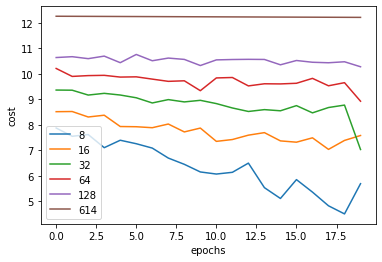

In [ ]:
# varying the batch size
batch_sizes=[8, 16, 32, 64, 128, int(0.8*768)]
error_list=[]
time_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=.80, random_state=42)

# error plots
for size in batch_sizes:
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train,batch_size=size))[0]
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'batch_size': batch_sizes, 'test_error': error_list}
varied_batch_size_df=pd.DataFrame.from_dict(error_data)
varied_batch_size_df.plot(x='batch_size', y='test_error')
plt.show()

# convergence speed plots
all_costs={}
for size in batch_sizes: # change size
  model=LinearRegression()
  fit_return_list=model.fit(x=X_train, y=y_train,batch_size=size) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(size)] = costs

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))

for key in all_costs:
  all_costs[key] = all_costs[key][0:40]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

### Varying learning rates

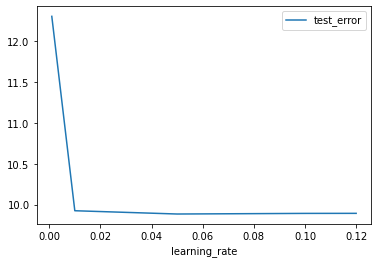

In [ ]:
# varying the learning rates

learning_rates=[0.001, 0.01, 0.05, 0.1, 0.12] # change Maybe get rid of 0.12
error_list=[]
time_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=.80, random_state=42)


# error plots
for lr in learning_rates: # change size and batch names
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train, learning_rate=lr))[0] # change
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'learning_rate': learning_rates, 'test_error': error_list} # change
varied__df=pd.DataFrame.from_dict(error_data)
varied__df.plot(x='learning_rate', y='test_error') # change
plt.show()

### Varying regularization parameter

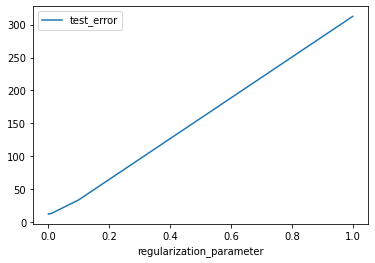

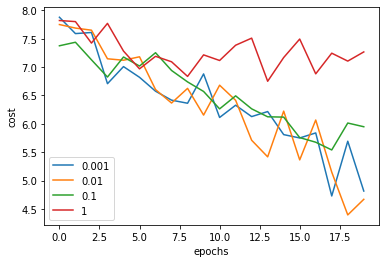

In [ ]:
# varying the regularization parameter
# around 7 changes

regularization_parameters=[0.001, 0.01, 0.1, 1] # change
error_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=.80, random_state=42)

# error plots
for rp in regularization_parameters: # change size and batch names
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train, l2_reg=rp))[0] # change
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'regularization_parameter': regularization_parameters, 'test_error': error_list} # change
varied__df=pd.DataFrame.from_dict(error_data)
varied__df.plot(x='regularization_parameter', y='test_error') # change
plt.show()

# convergence speed plots
all_costs={}
for rp in regularization_parameters: # change size
  model=LinearRegression()
  fit_return_list=model.fit(x=X_train, y=y_train,batch_size=8, l2_reg=rp) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(rp)] = costs

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))

for key in all_costs:
  all_costs[key] = all_costs[key][0:20]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

### Adding momentum and varying decay rate

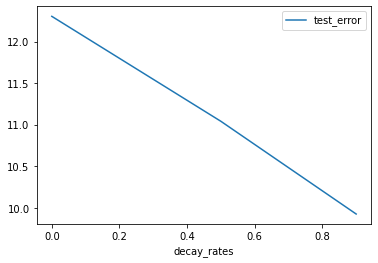

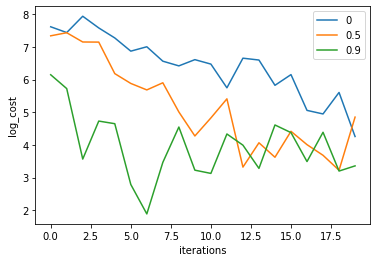

In [ ]:
# varying the regularization parameter
# around 7 changes

decay_rates=[0, 0.5, 0.9] # change
error_list=[]
X_train, X_test, y_train, y_test = train_test_split(X, y2, train_size=.80, random_state=42)

# error plots
for dr in decay_rates: # change size and batch names
  model=LinearRegression()
  weights=(model.fit(x=X_train, y=y_train, decay_rate=dr))[0] # change
  y_predict_test=model.predict(X_test)
  test_error=mean_squared_error(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'decay_rates': decay_rates, 'test_error': error_list} # change
varied__df=pd.DataFrame.from_dict(error_data)
varied__df.plot(x='decay_rates', y='test_error') # change
plt.show()

# convergence speed plots
all_costs={}
for dr in decay_rates: # change 
  model=LinearRegression()
  fit_return_list=model.fit(x=X_train, y=y_train, decay_rate=dr) # change
  costs=fit_return_list[1]
  all_costs[str(dr)] = costs # change

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))
all_costs
for key in all_costs:
  all_costs[key] = all_costs[key][0:20]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('iterations')
plt.ylabel('log_cost')
plt.show() # Better legend